# plot the mean state and variability of thermocline O2

In [1]:
%matplotlib inline
import os
from subprocess import call

import xarray as xr
import numpy as np
import cftime
from scipy import signal


from itertools import product

import cartopy
import cartopy.crs as ccrs
import  matplotlib.pyplot as plt

import geotools as gt
import plottools as pt

USER = os.environ['USER']

set up some options and time-weighting arrays

In [2]:
xr_open_ds = {'chunks' : {'time':1},
              'decode_coords' : False,
              'decode_times' : False}
xr.set_options(enable_cftimeindex=True)

year_range = np.array((249,316))+1699
time = [cftime.DatetimeNoLeap(year, month, 1) for year, month in 
                  product(range(year_range[0], year_range[1]+1), range(1, 13))]
ypm = np.array([31,28,31,30,31,30,31,31,30,31,30,31])/365
wgt = xr.DataArray(np.tile(ypm,int(np.diff(year_range)+1)),dims=('time'),coords={'time':time})

np.testing.assert_allclose(wgt.groupby('time.year').sum(),1.)

Start a dask cluster

In [3]:
import dask
from dask.distributed import Client
from dask_jobqueue import PBSCluster

dask.config.set({'distributed.dashboard.link':'http://localhost:{port}/status'})

# Lots of arguments to this command are set in ~/.config/dask/jobqueue.yaml
cluster = PBSCluster(queue='regular',
                     cores = 36,
                     processes = 9,
                     memory = '100GB',                     
                     project = 'NCGD0033',
                     walltime = '04:00:00',
                     local_directory=f'/glade/scratch/{USER}/dask-tmp')
client = Client(cluster)

In [4]:
cluster.scale(9*4)

Read a merged dataset

In [5]:
droot = '/glade/p_old/decpred/CESM-DPLE_POPCICEhindcast'

ds = xr.Dataset()
for v in ['PD','O2']:
    ds = xr.merge((ds,xr.open_dataset(f'{droot}/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.{v}.024901-031612.nc',**xr_open_ds)))

ds.time.values = time

grid_vars = [v for v in ds.variables if 'time' not in ds[v].dims]
ds.info()

xarray.Dataset {
dimensions:
	d2 = 2 ;
	lat_aux_grid = 395 ;
	moc_comp = 3 ;
	moc_z = 61 ;
	nlat = 384 ;
	nlon = 320 ;
	time = 816 ;
	transport_comp = 5 ;
	transport_reg = 2 ;
	z_t = 60 ;
	z_t_150m = 15 ;
	z_w = 60 ;
	z_w_bot = 60 ;
	z_w_top = 60 ;

variables:
	float64 REGION_MASK(nlat, nlon) ;
		REGION_MASK:long_name = basin index number (signed integers) ;
		REGION_MASK:coordinates = TLONG TLAT ;
	float64 fwflux_factor() ;
		fwflux_factor:long_name = Convert Net Fresh Water Flux to Salt Flux (in model units) ;
	float64 latent_heat_vapor() ;
		latent_heat_vapor:units = J/kg ;
		latent_heat_vapor:long_name = Latent Heat of Vaporization ;
	float32 z_t(z_t) ;
		z_t:units = centimeters ;
		z_t:long_name = depth from surface to midpoint of layer ;
		z_t:valid_min = 500.0 ;
		z_t:valid_max = 537500.0 ;
		z_t:positive = down ;
	float32 z_w(z_w) ;
		z_w:units = centimeters ;
		z_w:long_name = depth from surface to top of layer ;
		z_w:valid_min = 0.0 ;
		z_w:valid_max = 525000.9375 ;
		z_w:po

Add a variable for $\sigma_{\theta}$

In [6]:
ds['sigma'] = (ds.PD - 1.) * 1000.

Compute annual mean using weights defined above for monthly data

In [7]:
dsy = (ds.drop(grid_vars) * wgt).groupby('time.year').sum('time')
dsy = xr.merge((dsy,ds.drop([v for v in ds.variables if v not in grid_vars])))
dsy

<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, transport_comp: 5, transport_reg: 2, year: 68, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * z_t                   (z_t) float64 500.0 1.5e+03 2.5e+03 3.5e+03 ...
  * year                  (year) int64 1948 1949 1950 1951 1952 1953 1954 ...
  * z_w                   (z_w) float32 0.0 1000.0 2000.0 3000.0 4000.0 ...
  * moc_z                 (moc_z) float32 0.0 1000.0 2000.0 3000.0 4000.0 ...
  * z_w_top               (z_w_top) float32 0.0 1000.0 2000.0 3000.0 4000.0 ...
  * z_w_bot               (z_w_bot) float32 1000.0 2000.0 3000.0 4000.0 ...
  * lat_aux_grid          (lat_aux_grid) float32 -79.48815 -78.952896 ...
  * z_t_150m              (z_t_150m) float32 500.0 1500.0 2500.0 3500.0 ...
Dimensions without coordinates: d2, moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables:
    time_bound            (year, d2) float64 dask.

Compute the mean over the "thermocline" (200 <= z <= 600)

In [8]:
dsy = dsy.sel(z_t=slice(200e2,600e2)).mean('z_t')
dsy

<xarray.Dataset>
Dimensions:             (d2: 2, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, year: 68, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * year                (year) int64 1948 1949 1950 1951 1952 1953 1954 1955 ...
  * z_w                 (z_w) float32 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 ...
  * moc_z               (moc_z) float32 0.0 1000.0 2000.0 3000.0 4000.0 ...
  * z_w_top             (z_w_top) float32 0.0 1000.0 2000.0 3000.0 4000.0 ...
  * z_w_bot             (z_w_bot) float32 1000.0 2000.0 3000.0 4000.0 5000.0 ...
  * lat_aux_grid        (lat_aux_grid) float32 -79.48815 -78.952896 ...
  * z_t_150m            (z_t_150m) float32 500.0 1500.0 2500.0 3500.0 4500.0 ...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound          (year, d2) float64 dask.array<shape=(68, 2), chunksize=(1, 2)>
    PD                  (year, nlat, nlon) float64 dask.array<shape=(68, 384, 320), chunksize=(1, 384, 320)>
    O2            

compute a long-term mean

In [9]:
ds_mean = dsy.mean('year')
ds_mean

<xarray.Dataset>
Dimensions:             (d2: 2, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * z_w                 (z_w) float32 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 ...
  * moc_z               (moc_z) float32 0.0 1000.0 2000.0 3000.0 4000.0 ...
  * z_w_top             (z_w_top) float32 0.0 1000.0 2000.0 3000.0 4000.0 ...
  * z_w_bot             (z_w_bot) float32 1000.0 2000.0 3000.0 4000.0 5000.0 ...
  * lat_aux_grid        (lat_aux_grid) float32 -79.48815 -78.952896 ...
  * z_t_150m            (z_t_150m) float32 500.0 1500.0 2500.0 3500.0 4500.0 ...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound          (d2) float64 dask.array<shape=(2,), chunksize=(2,)>
    PD                  (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 320)>
    O2                  (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 320)>
    sigma               (nlat, nlon) 

Some quick check plots

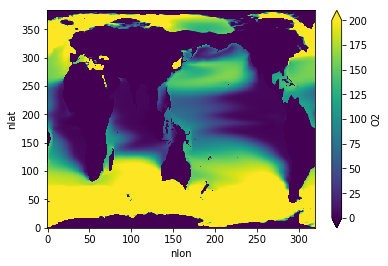

In [10]:
ds_mean.O2.plot(vmin=0,vmax=200)

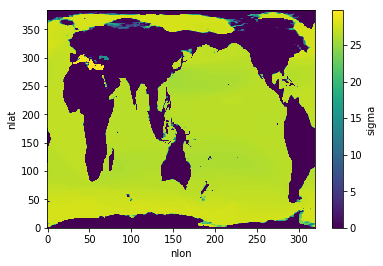

In [11]:
ds_mean.sigma.plot()

In [12]:
o2_global = gt.weighted_mean(dsy.O2,dsy.TAREA,['nlat','nlon'])
o2_global

<xarray.DataArray (year: 68)>
dask.array<shape=(68,), dtype=float64, chunksize=(1,)>
Coordinates:
  * year     (year) int64 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 ...

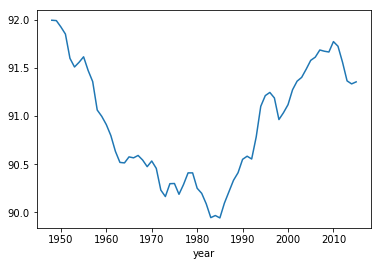

In [13]:
o2_global.plot()

In [15]:
valid = dsy.O2.notnull()
O2_dtrend = xr.full_like(dsy.O2,fill_value=-999.)
O2_dtrend.values = signal.detrend(dsy.O2.fillna(0),axis=0)
O2_dtrend = O2_dtrend.where(valid)
O2_dtrend

<xarray.DataArray 'O2' (year: 68, nlat: 384, nlon: 320)>
dask.array<shape=(68, 384, 320), dtype=float64, chunksize=(1, 384, 320)>
Coordinates:
  * year     (year) int64 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 ...
Dimensions without coordinates: nlat, nlon

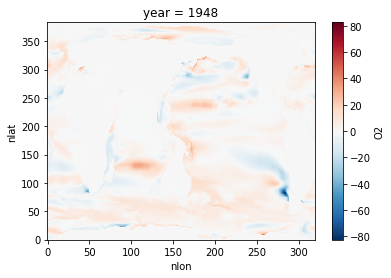

In [17]:
O2_dtrend.isel(year=0).plot()

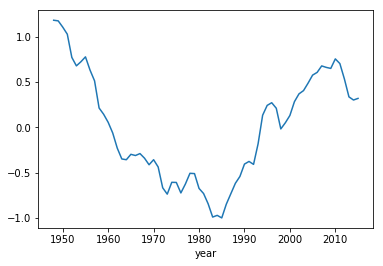

In [18]:
o2_global = gt.weighted_mean(O2_dtrend,ds.TAREA,['nlat','nlon'])
o2_global.plot()

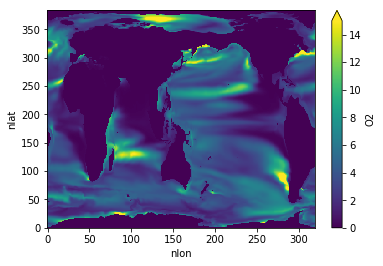

In [19]:
o2_std = O2_dtrend.std('year')
o2_std.plot(vmin=0,vmax=15)

In [ ]:
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,o2_std.values)

levels = np.arange(0,16,1)

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                levels=levels,cmap='Blues',extend='max')

#-- add contour lines
cs = ax.contour(lon,lat,field,
                colors='k',
                levels = levels,
                linewidths = 0.5,
                transform=ccrs.PlateCarree(),
                zorder=len(cf.collections)+10)

#-- add contour labels
cs.levels = [pt.contour_label_format(val) for val in cs.levels]
fmt = '%r'
lb = plt.clabel(cs, fontsize=6,
               inline = True,
               fmt=fmt)

land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'))

plt.subplots_adjust(hspace=0.45,wspace=0.2,right=0.9)
cax = plt.axes((0.93, 0.15, 0.02, 0.7))
plt.colorbar(cf,cax=cax)

In [ ]:
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,ds_mean.O2.values)

norm_o2 = pt.MidPointNorm(midpoint=60.)
cf_specs = {'levels':[0,10,20,30,40,50,60,80,100,125,150,175,200,225,250,275,300],
            'cmap':'PRGn',
            'norm':norm_o2,
            'extend':'both'}

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),**cf_specs)


land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                  edgecolor='face',
                  facecolor='gray'))

plt.subplots_adjust(hspace=0.45,wspace=0.2,right=0.9)
cax = plt.axes((0.93, 0.15, 0.02, 0.7))
plt.colorbar(cf,cax=cax)